In [108]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from feature_engine.outliers import Winsorizer
from category_encoders import CountEncoder, OneHotEncoder, OrdinalEncoder, CatBoostEncoder



from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor  as VIF
import sklearn.preprocessing as skpp
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from statsmodels.api import OLS, add_constant
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit
from sklearn import metrics

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectFwe, f_regression, SelectKBest, SelectFromModel

import catboost
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
import lineartree as lt

import optuna

from IPython.core.display import HTML
import warnings, os, itertools, sys
import yaml

sys.path.append('../utils')
import lp_utils


plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

import warnings
warnings.filterwarnings("ignore")

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [110]:
final_dataset = pd.read_pickle('../data/final_dataset.pkl')
outlier_search = pd.read_excel('../data/upper_outlier_search.xlsx', sheet_name='summary')

In [111]:
exclude = outlier_search[(outlier_search.SIGMA_OUTLIER==1)&(outlier_search.INFLOW_OUTLIER==1)].APP_ID.unique()

In [112]:
final_dataset[final_dataset.app_id.isin(exclude)].shape

(18, 167)

In [113]:
final_dataset = final_dataset[final_dataset.app_id.isin(exclude)==False]

In [114]:
final_dataset = final_dataset[(final_dataset.avg_mly_inflow>1250)&(final_dataset.num_months_with_trn>=9)]

In [115]:
final_dataset['ratio'] = final_dataset.target/final_dataset.avg_mly_inflow
final_dataset['ratio_log'] = np.log(final_dataset.ratio)

In [116]:
final_dataset[['ratio','ratio_log']].describe(percentiles=np.linspace(0,1,11))

,ratio,ratio_log
count,2022.000000,2022.000000
mean,0.253906,-1.819505
std,0.257637,1.047297
min,0.001289,-6.654054
0%,0.001289,-6.654054
10%,0.041537,-3.181186
20%,0.075195,-2.587667
30%,0.103520,-2.267995
40%,0.141571,-1.954956
50%,0.181505,-1.706474


In [117]:
def clip_dataset(data, low, upp, cap=True):
    
    mean, std = data['ratio_log'].mean(), data['ratio_log'].std()
    lower, upper = mean -  low *  std, mean +  upp *  std
    print(np.exp(upper), np.exp(lower))
    data['cap_amount'] = np.exp(upper) * data.avg_mly_inflow

    data = data[(data['ratio_log']>lower)]
    
    if cap:
        data['target'] = np.where(data.ratio_log > upper, data.cap_amount, data.target)
    else:
        data = data[(data['ratio_log']<upper)]
        
    return data.reset_index(drop=True)

In [118]:
df = clip_dataset(final_dataset, 1.5, 1.5, True)

0.7799233933894613 0.03369348623192825


In [119]:
df.ratio.describe()

count   1870.000000
mean       0.272979
std        0.258701
min        0.034070
25%        0.105780
50%        0.201041
75%        0.351100
max        2.955049
Name: ratio, dtype: float64

In [120]:
df[df['ratio']>1].shape

(41, 170)

In [121]:
df.shape

(1870, 170)

# 42

In [122]:
n_bins = 10
df['target_bin'] = pd.qcut(df['target'], q=n_bins, labels=False)

In [123]:
# Create empty lists to hold the train and test data
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Split the data by target bin
for bin in df['target_bin'].unique():
    bin_data = df[df['target_bin'] == bin]

    # Get unique groups in this bin
    unique_groups = bin_data['customer_id'].unique()

    # Split groups into train and test
    train_groups, test_groups = train_test_split(unique_groups, test_size=0.25, random_state=1)

    # Get all the instances for these groups
    bin_train = bin_data[bin_data['customer_id'].isin(train_groups)]
    bin_test = bin_data[bin_data['customer_id'].isin(test_groups)]

    # Append this bin's data to the train and test data
    train_df = pd.concat([train_df, bin_train])
    test_df = pd.concat([test_df, bin_test])



In [124]:
train_df.shape, test_df.shape

((1391, 171), (479, 171))

In [125]:
train = train_df.copy()
test = test_df.copy()

In [184]:
train[train.is_disb==0].shape

(428, 172)

In [185]:
1159 + (428-193)

1394

In [126]:
wr = Winsorizer(capping_method='gaussian', tail='right', fold=1.5)
train['target'] = wr.fit_transform(train[['target']])
test['target'] = wr.transform(test[['target']])

In [127]:
train.target.max()

40655.61020334992

In [128]:
# Create a new column for the loan amount bins
train['fold'] = -1

# Create a dictionary to hold the fold assignment for each customer_id
group_to_fold = {}

# For each bin, split the groups into folds
for bin in train['target_bin'].unique():
    bin_data = train[train['target_bin'] == bin]
    unique_groups = bin_data['customer_id'].unique()
    
    np.random.seed(1)
    # Shuffle the unique groups
    np.random.shuffle(unique_groups)

    # Split the groups into 5 folds
    folds = np.array_split(unique_groups, 5)

    # Assign fold numbers to the groups
    for fold, test_groups in enumerate(folds):
        for group in test_groups:
            group_to_fold[group] = fold

# Assign the fold number in the dataframe using the group_to_fold dictionary
train['fold'] = train['customer_id'].map(group_to_fold)

In [129]:
train.fold.value_counts()

3    306
4    292
0    278
2    264
1    251
Name: fold, dtype: int64

In [130]:
train.target.max()

40655.61020334992

In [131]:
with open(file = '../config/features.yaml') as yaml_file:
    fts = yaml.safe_load(stream = yaml_file)
    
BINARY_FEATURES = [f for f in fts['binary'] if 'tax' not in f and '12m' not in f]
CATEGORICAL_FEATURES = fts['category']

trns = fts['continuous']['transactional']

trns_list = fts['continuous']['business_specific'] + trns['trn']['amount'] + trns['trn']['count'] + trns['trn']['ratio'] + trns['inflow']['amount'] + \
            trns['inflow']['count'] + trns['inflow']['ratio'] + trns['trend'] + trns['growth'] + trns['top_buyer'] + trns['top_supplier']

chist = fts['continuous']['credit_history']
chist_list = chist['amount'] + chist['count']

unwanted_features = ['90', '30', 'ncf', 'net_cashflow', 'active', 'outstanding', 'deposit', 'exposure',
                    'salary', 'wage', 'tax', 'amt_trn', 'avg_trn_amt']

CONTINUOUS_FEATURES = [col for col in trns_list + chist_list if not any(f for f in unwanted_features if f in col) if not col.startswith('sh')]

ONE_IMP_F = [f for f in CONTINUOUS_FEATURES if 'trend' in f if not 'top' in f]
ZERO_IMP_F = [f for f in CONTINUOUS_FEATURES if f not in ONE_IMP_F]

In [132]:
BINARY_FEATURES

['is_pe', 'cr_hist_exist', 'sh_cr_hist_exist']

In [133]:
train['industry'] = train['industry'].str.replace(' |,','_')
test['industry'] = test['industry'].str.replace(' |,','_')

In [134]:
X = train[BINARY_FEATURES + CATEGORICAL_FEATURES + CONTINUOUS_FEATURES]
y = train['target']

In [135]:
def objective(trial):
    
    params = {
        'alpha': trial.suggest_float("alpha", 0.0001, 1),
        'l1_ratio': trial.suggest_float("l1_ratio", 0.01, 1),
        'random_state': 1
    }
        
    
    cat_model = ElasticNet(**params)

    
    bin_p = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
                      ('convert', lp_utils.ColumnsToIntTransformer())])
    cat_p = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='not_given')), 
                      ('encoder', skpp.OneHotEncoder(min_frequency=0.05, sparse_output=False, handle_unknown='ignore'))])


    one_imputation = Pipeline([('one_imputer', SimpleImputer(strategy='constant', fill_value=1))])
    zero_imputation = Pipeline([('zero_imputer', SimpleImputer(strategy='constant', fill_value=0))])

    imputation = ColumnTransformer([('one_imputation', one_imputation, ONE_IMP_F), ('zero_imputation', zero_imputation, ZERO_IMP_F)])


    con_p = Pipeline([ ('imputer', imputation), 
                       ('winsorize', Winsorizer(capping_method='gaussian', tail='both', fold=2.5)),
                       ('scaler', RobustScaler()),
                       ('select', SelectFwe(score_func=f_regression, alpha=0.05)),
                       ('vif_dropper', lp_utils.PearsonTest(threshold=0.8))
                       ])


    transformer = ColumnTransformer([('bin_p', bin_p, BINARY_FEATURES),
                                     ('cat_p', cat_p, CATEGORICAL_FEATURES), 
                                     ('con_p', con_p, CONTINUOUS_FEATURES)]).set_output(transform='pandas')

    pipeline = Pipeline([('transformer', transformer), ('selector', SelectFromModel(cat_model, max_features=20)), ('model', cat_model)]).set_output(transform='pandas')

    r2s, adj_r2s, mapes, train_r2s, train_adj_r2s, train_mapes = cross_val(pipeline, train)
    
    
    print(f"Train: MAE {np.mean(train_mapes)}, R2 {np.mean(train_r2s)}, Adjusted R2 {np.mean(train_adj_r2s)}")
    print(f"MAE {np.mean(mapes)}, R2 {np.mean(r2s)}, Adjusted R2 {np.mean(adj_r2s)}")
    
    return np.mean(mapes)

In [136]:
def cross_val(pipeline, train_data):
    
    # Define an empty list to store the cross-validation scores
    cv_mape_scores = []
    cv_r2_scores = []
    cv_adj_r2_scores = []
    
    train_cv_mape_scores = []
    train_cv_r2_scores = []
    train_cv_adj_r2_scores = []

    # Iterate over the folds
    for fd in train.fold.unique():
        

        # Split the data into training and test sets for this fold
        X_train, X_test = train_data[train_data.fold!=fd], train_data[train_data.fold==fd]
        y_train, y_test = train_data[train_data.fold!=fd]['target'], train_data[train_data.fold==fd]['target']


        # Fit the pipeline to the training data for this fold
        pipeline.fit(X_train, y_train)

        # Make predictions on the test data for this fold
        y_pred = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)


        n = len(y_test)
        n_train = len(y_train)
        p = pipeline[-1].n_features_in_
    

        train_r2 = metrics.r2_score(y_train, y_pred_train)
        train_adj_r2 = 1 - ((1 - train_r2) * (n_train - 1) / (n_train-p-1))
        train_mape = metrics.mean_absolute_error(y_train, y_pred_train)
        

        r2 = metrics.r2_score(y_test, y_pred)
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n-p-1))
        mape = metrics.mean_absolute_error(y_test, y_pred)

        cv_r2_scores.append(r2)
        cv_adj_r2_scores.append(adj_r2)
        cv_mape_scores.append(mape)
        
        
        train_cv_r2_scores.append(train_r2)
        train_cv_adj_r2_scores.append(train_adj_r2)
        train_cv_mape_scores.append(train_mape)
        
        
    return cv_r2_scores,cv_adj_r2_scores, cv_mape_scores, train_cv_r2_scores,train_cv_adj_r2_scores,train_cv_mape_scores
    

In [137]:
def tune(objective):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(
                            seed=1))
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return study

In [138]:
study = tune(objective)

[I 2023-06-22 16:16:08,470] A new study created in memory with name: no-name-89f84e62-7301-467b-88c4-777ecbad35fb


  0%|          | 0/100 [00:00<?, ?it/s]

Train: MAE 4010.37965565419, R2 0.655512775861941, Adjusted R2 0.6530242443966952
MAE 4234.934434839073, R2 0.6134122540258427, Adjusted R2 0.6017963448064714
[I 2023-06-22 16:16:10,315] Trial 0 finished with value: 4234.934434839073 and parameters: {'alpha': 0.41708030250210376, 'l1_ratio': 0.7231212485077365}. Best is trial 0 with value: 4234.934434839073.
Train: MAE 4020.877624151465, R2 0.6528972367308865, Adjusted R2 0.649871900777292
MAE 4195.934977386732, R2 0.6179360553168571, Adjusted R2 0.6042541430623788
[I 2023-06-22 16:16:12,217] Trial 1 finished with value: 4195.934977386732 and parameters: {'alpha': 0.00021436337986315216, 'l1_ratio': 0.30930924690552136}. Best is trial 1 with value: 4195.934977386732.
Train: MAE 4019.245842653665, R2 0.6546469073865661, Adjusted R2 0.652215268828471
MAE 4240.210320708519, R2 0.6127150379087178, Adjusted R2 0.6014177403932675
[I 2023-06-22 16:16:13,907] Trial 2 finished with value: 4240.210320708519 and parameters: {'alpha': 0.1468412152

Train: MAE 4012.6562968567523, R2 0.6553321656786608, Adjusted R2 0.6528422580247384
MAE 4236.181249431943, R2 0.6133304285238161, Adjusted R2 0.6017109510908949
[I 2023-06-22 16:16:47,280] Trial 22 finished with value: 4236.181249431943 and parameters: {'alpha': 0.5214915901368173, 'l1_ratio': 0.769839824152817}. Best is trial 16 with value: 4188.458511689904.
Train: MAE 4023.1344756756007, R2 0.6543417909663931, Adjusted R2 0.6518482180479193
MAE 4255.985171089056, R2 0.6112904163192997, Adjusted R2 0.599593565901934
[I 2023-06-22 16:16:48,911] Trial 23 finished with value: 4255.985171089056 and parameters: {'alpha': 0.28172519528614975, 'l1_ratio': 0.4541054064715536}. Best is trial 16 with value: 4188.458511689904.
Train: MAE 4001.067415747844, R2 0.6554971416875244, Adjusted R2 0.652433080079103
MAE 4218.769328039139, R2 0.6101203621872247, Adjusted R2 0.5958706922952874
[I 2023-06-22 16:16:50,545] Trial 24 finished with value: 4218.769328039139 and parameters: {'alpha': 0.0986824

Train: MAE 4003.423327640502, R2 0.6551606719649727, Adjusted R2 0.6522223119005448
MAE 4200.747506188254, R2 0.6123779011229067, Adjusted R2 0.5988267344848064
[I 2023-06-22 16:17:23,213] Trial 44 finished with value: 4200.747506188254 and parameters: {'alpha': 0.6657842971957827, 'l1_ratio': 0.9735977606611927}. Best is trial 41 with value: 4152.899209055319.
Train: MAE 4004.8531120833627, R2 0.6545433906551217, Adjusted R2 0.6517882957031684
MAE 4189.730946458281, R2 0.6133572162646171, Adjusted R2 0.6007463850378516
[I 2023-06-22 16:17:24,846] Trial 45 finished with value: 4189.730946458281 and parameters: {'alpha': 0.7917634864883951, 'l1_ratio': 0.9650893432500242}. Best is trial 41 with value: 4152.899209055319.
Train: MAE 4007.045034865159, R2 0.6557691979975864, Adjusted R2 0.6532826152676279
MAE 4233.041061092522, R2 0.613542343848511, Adjusted R2 0.6019320896003062
[I 2023-06-22 16:17:26,502] Trial 46 finished with value: 4233.041061092522 and parameters: {'alpha': 0.8799044

Train: MAE 4003.0883234896473, R2 0.6549574429891731, Adjusted R2 0.652205487104596
MAE 4195.816373577261, R2 0.6136537225520253, Adjusted R2 0.6010338465051389
[I 2023-06-22 16:17:59,348] Trial 66 finished with value: 4195.816373577261 and parameters: {'alpha': 0.9415819004056408, 'l1_ratio': 0.9696392548797086}. Best is trial 57 with value: 4152.878732160157.
Train: MAE 4165.681399162738, R2 0.6380051337893056, Adjusted R2 0.6352462293722129
MAE 4273.4772612017205, R2 0.6113046293326663, Adjusted R2 0.5992331708575919
[I 2023-06-22 16:18:01,008] Trial 67 finished with value: 4273.4772612017205 and parameters: {'alpha': 0.8162595245780653, 'l1_ratio': 0.24571824106793133}. Best is trial 57 with value: 4152.878732160157.
Train: MAE 4085.873233464841, R2 0.648494066019782, Adjusted R2 0.6458142651098756
MAE 4234.991231333397, R2 0.6112506273803369, Adjusted R2 0.599140913379909
[I 2023-06-22 16:18:02,670] Trial 68 finished with value: 4234.991231333397 and parameters: {'alpha': 0.725810

Train: MAE 4016.4574301759812, R2 0.6548654222099919, Adjusted R2 0.652435398531553
MAE 4238.32884894352, R2 0.6128457922470302, Adjusted R2 0.6015536118362454
[I 2023-06-22 16:18:36,434] Trial 88 finished with value: 4238.32884894352 and parameters: {'alpha': 0.6445930898914098, 'l1_ratio': 0.8042785485415295}. Best is trial 57 with value: 4152.878732160157.
Train: MAE 4047.3203387863005, R2 0.652664706303451, Adjusted R2 0.6498967534431619
MAE 4246.177673103217, R2 0.611124060350946, Adjusted R2 0.5984396007110816
[I 2023-06-22 16:18:38,118] Trial 89 finished with value: 4246.177673103217 and parameters: {'alpha': 0.8510766823975687, 'l1_ratio': 0.7504586658596284}. Best is trial 57 with value: 4152.878732160157.
Train: MAE 4003.326040279945, R2 0.6549387388309971, Adjusted R2 0.6521866348487613
MAE 4195.734317449579, R2 0.6136751045949946, Adjusted R2 0.601055689383857
[I 2023-06-22 16:18:39,800] Trial 90 finished with value: 4195.734317449579 and parameters: {'alpha': 0.57806767929

In [139]:
bparams = study.best_params
bparams

{'alpha': 0.8886186849090418, 'l1_ratio': 0.9621289283942136}

In [140]:
def get_scores(pipeline, y_true, y_preds):
    
    n = len(y_true)
    k = pipeline[-1].n_features_in_
    
    r2 = metrics.r2_score(y_true, y_preds)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    
    mape = metrics.mean_absolute_error(y_true, y_preds)
    
    return r2, adj_r2, mape

In [141]:
def create_pipln(bparams):

    params = {
    'alpha': bparams['alpha'],
    'l1_ratio': bparams['l1_ratio'],
    'random_state': 1
    }



    cat_model = ElasticNet(**params)
    
    
    
    bin_p = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
                      ('convert', lp_utils.ColumnsToIntTransformer())])
    cat_p = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='not_given')), 
                      ('encoder', skpp.OneHotEncoder(min_frequency=0.05, sparse_output=False, handle_unknown='ignore'))])


    one_imputation = Pipeline([('one_imputer', SimpleImputer(strategy='constant', fill_value=1))])
    zero_imputation = Pipeline([('zero_imputer', SimpleImputer(strategy='constant', fill_value=0))])

    imputation = ColumnTransformer([('one_imputation', one_imputation, ONE_IMP_F), ('zero_imputation', zero_imputation, ZERO_IMP_F)])


    con_p = Pipeline([ ('imputer', imputation), 
                       ('winsorize', Winsorizer(capping_method='gaussian', tail='both', fold=2.5)),
                       ('scaler', RobustScaler()),
                       ('select', SelectFwe(score_func=f_regression, alpha=0.05)),
                       ('vif_dropper', lp_utils.PearsonTest(threshold=0.8))
                       ])


    transformer = ColumnTransformer([('bin_p', bin_p, BINARY_FEATURES),
                                     ('cat_p', cat_p, CATEGORICAL_FEATURES), 
                                     ('con_p', con_p, CONTINUOUS_FEATURES)]).set_output(transform='pandas')

    pipeline = Pipeline([('transformer', transformer), ('selector', SelectFromModel(cat_model, max_features=20)), ('model', cat_model)]).set_output(transform='pandas')
    
    return pipeline






def get_params_optuna(study, model_num, minimize):
    top5 = study.trials_dataframe().sort_values('value', ascending=minimize).iloc[:5, 5:-1].reset_index(drop=True)
    top5.columns = [col.split('params_')[1] for col in top5.columns]
    
    return top5.iloc[model_num:model_num+1].to_dict('records')[0]




def evaluate_model(study, train, test, model_num, minimize):
    
    bparams = get_params_optuna(study, model_num, minimize)
    
    X_train, y_train = train[BINARY_FEATURES+CATEGORICAL_FEATURES+CONTINUOUS_FEATURES], train['target']
    X_test, y_test = test[BINARY_FEATURES+CATEGORICAL_FEATURES+CONTINUOUS_FEATURES], test['target']
    
    final_pipeline = create_pipln(bparams)
    final_pipeline.fit(X_train, y_train)
    
    y_pred_train = final_pipeline.predict(X_train)
    y_pred_test = final_pipeline.predict(X_test)
    
    r2_train, adj_r2_train, mape_train = get_scores(final_pipeline, y_train, y_pred_train)
    r2_test, adj_r2_test, mape_test = get_scores(final_pipeline, y_test, y_pred_test)
    
    
    pipeline_cv = create_pipln(bparams)
    cv_r2_scores,cv_adj_r2_scores, cv_mape_scores, train_cv_r2_scores,train_cv_adj_r2_scores,train_cv_mape_scores = cross_val(pipeline_cv, train)
    
    train_mse = metrics.mean_squared_error(y_train, y_pred_train)
    test_mse = metrics.mean_squared_error(y_test, y_pred_test)
    rel_diff = test_mse/train_mse - 1

    
    scores_dict = {
        'Model': 'ElasticNet Optimized on MAE',
        'Specs': 'Fwe w/ p=0.05, Pearson thr = 0.8',
        'Train size': train.shape[0],
        'Test size': test.shape[0],
        'Features': final_pipeline[-1].n_features_in_,
        'Train_R2': r2_train,
        'Train_Adj_R2': adj_r2_train,
        'Train_MAE': mape_train,
        'CV_R2': np.mean(cv_r2_scores),
        'CV_Adj_R2': np.mean(cv_adj_r2_scores),
        'CV_MAE': np.mean(cv_mape_scores),
        'CV_MAE_std': np.std(cv_mape_scores),
        'CV_ADJ_R2_std': np.std(cv_adj_r2_scores),
        'Test_R2': r2_test,
        'Test_Adj_R2': adj_r2_test,
        'Test_MAE': mape_test,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Rel. diff. MSE':rel_diff
    }
    
    scores_df = pd.DataFrame(scores_dict, index=[0])
    
    return final_pipeline, scores_df

In [142]:
get_params_optuna(study, 2, True)

{'alpha': 0.7700241518264183, 'l1_ratio': 0.9582874928650889}

In [143]:
pipeline1,s1 = evaluate_model(study, train, test, 0, True)

In [144]:
pipeline2,s2 = evaluate_model(study, train, test, 1, True)

In [145]:
pipeline3,s3 =evaluate_model(study, train, test, 2, True)

In [146]:
pipeline4,s4 =evaluate_model(study, train, test, 3, True)

In [147]:
pipeline5,s5 =evaluate_model(study, train, test, 4, True)

In [148]:
study.trials_dataframe().sort_values('value', ascending=True).iloc[:5, :-1].reset_index(drop=True)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_l1_ratio
0,57,4152.878732,2023-06-22 16:17:42.975712,2023-06-22 16:17:44.628136,0 days 00:00:01.652424,0.888619,0.962129
1,41,4152.899209,2023-06-22 16:17:16.676322,2023-06-22 16:17:18.309032,0 days 00:00:01.632710,0.760776,0.955553
2,43,4153.391243,2023-06-22 16:17:19.942021,2023-06-22 16:17:21.578822,0 days 00:00:01.636801,0.770024,0.958287
3,61,4153.524407,2023-06-22 16:17:49.524262,2023-06-22 16:17:51.150471,0 days 00:00:01.626209,0.777143,0.959213
4,73,4153.628814,2023-06-22 16:18:09.313564,2023-06-22 16:18:10.960420,0 days 00:00:01.646856,0.776662,0.959597


In [149]:
results = pd.concat([s1, s2, s3, s4, s5]).reset_index(drop=True)

In [150]:
results

,Model,Specs,Train size,Test size,Features,Train_R2,Train_Adj_R2,Train_MAE,CV_R2,CV_Adj_R2,CV_MAE,CV_MAE_std,CV_ADJ_R2_std,Test_R2,Test_Adj_R2,Test_MAE,Train MSE,Test MSE,Rel. diff. MSE
0,ElasticNet Optimized on MAE,"Fwe w/ p=0.05, Pearson thr = 0.8",1391,479,9,0.643416,0.641092,4068.173464,0.620016,0.607220,4152.878732,255.046537,0.053611,0.612703,0.605271,3697.107625,39407791.824896,33377052.977103,-0.153034
1,ElasticNet Optimized on MAE,"Fwe w/ p=0.05, Pearson thr = 0.8",1391,479,9,0.643414,0.641090,4068.246684,0.620016,0.607220,4152.899209,255.017747,0.053608,0.612705,0.605273,3697.146805,39408036.562192,33376870.580719,-0.153044
2,ElasticNet Optimized on MAE,"Fwe w/ p=0.05, Pearson thr = 0.8",1391,479,9,0.643467,0.641143,4067.492935,0.619941,0.607143,4153.391243,256.017961,0.053711,0.612671,0.605238,3696.732520,39402149.308615,33379811.949220,-0.152843
3,ElasticNet Optimized on MAE,"Fwe w/ p=0.05, Pearson thr = 0.8",1391,479,9,0.643480,0.641156,4067.306060,0.619922,0.607123,4153.524407,256.265536,0.053737,0.612662,0.605229,3696.628602,39400726.289123,33380546.737295,-0.152794
4,ElasticNet Optimized on MAE,"Fwe w/ p=0.05, Pearson thr = 0.8",1391,479,9,0.643490,0.641166,4067.165436,0.619907,0.607108,4153.628814,256.456599,0.053757,0.612656,0.605223,3696.550479,39399645.448561,33381115.689591,-0.152756


In [151]:
results.iloc[0]

Model                  ElasticNet Optimized on MAE
Specs             Fwe w/ p=0.05, Pearson thr = 0.8
Train size                                    1391
Test size                                      479
Features                                         9
Train_R2                                  0.643416
Train_Adj_R2                              0.641092
Train_MAE                              4068.173464
CV_R2                                     0.620016
CV_Adj_R2                                 0.607220
CV_MAE                                 4152.878732
CV_MAE_std                              255.046537
CV_ADJ_R2_std                             0.053611
Test_R2                                   0.612703
Test_Adj_R2                               0.605271
Test_MAE                               3697.107625
Train MSE                          39407791.824896
Test MSE                           33377052.977103
Rel. diff. MSE                           -0.153034
Name: 0, dtype: object

In [152]:
# results.to_excel('results/elasticnet_mae_thr80_wo_exposure.xlsx', index=False)

In [153]:
feature_importances = pipeline1[-1].coef_

In [154]:
feature_names = pipeline1[:-1].transform(X).columns

In [155]:
feature_names = ['_'.join(name.split('__')[1:]) for name in feature_names]
feature_names.append('intercept')

In [156]:
intercept = pipeline1[-1].intercept_
fimp = pd.DataFrame(list(feature_importances) + [intercept], index=feature_names, columns=['value']).reset_index()
fimp = fimp.sort_values('value', ascending=True)

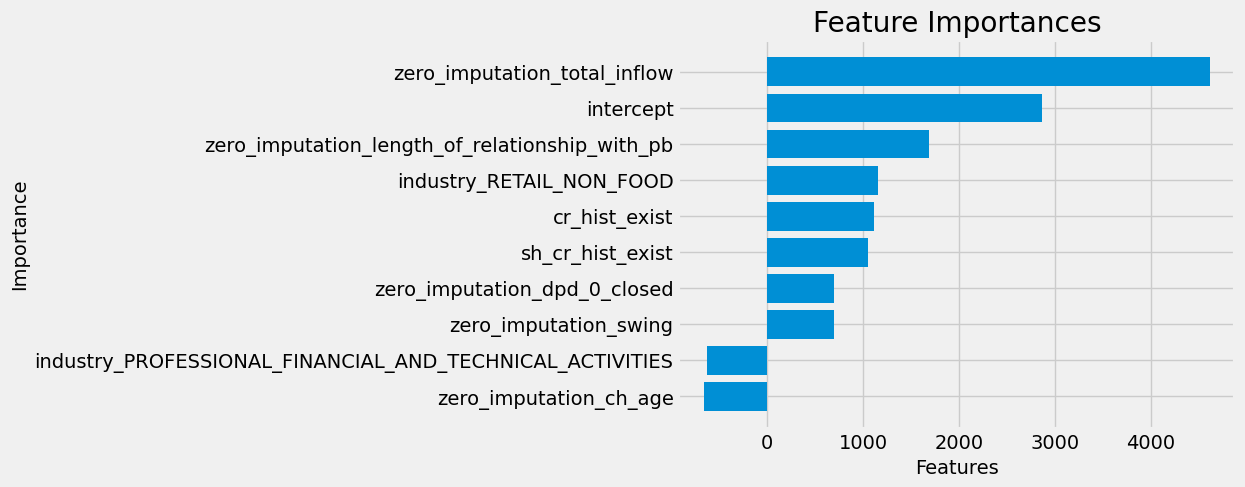

In [157]:
# Create a bar plot of feature importances
plt.barh(fimp['index'], fimp['value'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [158]:
fimp.reset_index(drop=True)

,index,value
0,zero_imputation_ch_age,-663.019992
1,industry_PROFESSIONAL_FINANCIAL_AND_TECHNICAL_...,-626.285149
2,zero_imputation_swing,698.497201
3,zero_imputation_dpd_0_closed,699.185514
4,sh_cr_hist_exist,1047.394607
5,cr_hist_exist,1111.595604
6,industry_RETAIL_NON_FOOD,1154.304090
7,zero_imputation_length_of_relationship_with_pb,1684.655660
8,intercept,2860.505925
9,zero_imputation_total_inflow,4614.226686


In [159]:
pipeline1[-1].intercept_

2860.5059253546733

In [160]:
y_test_pred = pipeline1.predict(test)
y_train_pred = pipeline1.predict(train)

In [161]:
import joblib

In [162]:
# joblib.dump(pipeline1, 'final_pipeline.pkl')

In [163]:
train.head()

,app_id,balance_trend,total_inflow,avg_monthly_trn_count,spending,swing,days_since_last_trn,cash_inflow_trend,top_buyer_conc_trend,top_buyer_trn_frequency,top_supplier_trn_frequency,balance_swing_ratio,tax_ratio,cash_inflow_3m_trend,cash_in_ratio,top_buyer_conc_3m_trend,salary_ratio,top_null_supplier_ratio,trn_count_3m_trend,amt_trn,avg_cash_inflow,avg_cash_outflow,avg_mly_inflow,avg_mly_outflow,avg_monthly_inflow_count,avg_monthly_outflow_count,avg_ncf,avg_num_days_between_inflows,avg_num_days_between_inflows_trend,avg_num_days_between_outflows_trend,avg_num_days_between_payments,avg_trn_amt,avg_trnvr_1m_to_avg_trnvr_6m,avg_trnvr_3m_to_avg_trnvr_6m,avg_wage_to_inflow,b2b_ratio,balance_growth,cash_deposit_ratio,cash_in,cash_outflow_3m_trend,cash_outflow_trend,current_pb_balance,days_since_last_inflow,days_since_last_outflow,incoming_trn_count,inflow_count_3m_trend,inflow_count_trend,max_outflow_to_total_outflow,median_monthly_inflow_count,median_monthly_outflow_count,median_monthly_trn_count,months_w_inflow_ratio,ncf_growth,ncf_trend,net_cashflow,num_months_with_trn,num_months_wo_trn,outflow_count_3m_trend,outflow_count_trend,outflow_to_inflow,outgoing_trn_count,salary,std_incoming_trn_amount,std_outgoing_trn_amount,tax_payments,top_buyer_change,top_null_buyer_ratio,top_supplier_change,top_supplier_conc_3m_trend,top_supplier_conc_trend,trn_amount_trend,trn_count_trend,num_months_w_inflow,num_months_w_outflow,balance_spending_ratio,tabaterra_turnover,cash_deposits,balance_risk_growth,trn_amount_risk_growth,cash_inflow_risk_growth,ncf_risk_growth,cash_outflow_risk_growth,has_tax_statement_fixed,business_age_days,industry_sub_sector,days_since_last_open_loan,days_since_first_loan,max_dpd,request_count_last_3m,cr_hist_exist,closed_amt,outstanding_amt,dpd_0_active,dpd_10_active,dpd_30_active,dpd_90_active,dpd_0_closed,dpd_10_closed,dpd_30_closed,dpd_90_closed,dpd_0,dpd_10,dpd_30,dpd_90,num_active_loans,num_closed_loans,number_of_creditors,non_pb_exposure,non_delinquent_loan_cnt,non_delinquent_loan_amt,non_delinquent_active_loan_cnt,non_delinquent_active_loan_amt,non_delinquent_closed_loan_cnt,non_delinquent_closed_loan_amt,current_dpd,ch_age,length_of_relationship_with_pb,cr_hist_12m_exists,max_closed_amt_2years,max_closed_amt_1year,sh_days_since_last_open_loan,sh_days_since_first_loan,sh_max_dpd,sh_request_count_last_3m,sh_cr_hist_exist,sh_closed_amt,sh_outstanding_amt,sh_dpd_0_active,sh_dpd_10_active,sh_dpd_30_active,sh_dpd_90_active,sh_dpd_0_closed,sh_dpd_10_closed,sh_dpd_30_closed,sh_dpd_90_closed,sh_dpd_0,sh_dpd_10,sh_dpd_30,sh_dpd_90,sh_num_active_loans,sh_num_closed_loans,sh_number_of_creditors,sh_non_pb_exposure,sh_non_delinquent_loan_cnt,sh_non_delinquent_loan_amt,sh_non_delinquent_active_loan_cnt,sh_non_delinquent_active_loan_amt,sh_non_delinquent_closed_loan_cnt,sh_non_delinquent_closed_loan_amt,sh_current_dpd,sh_ch_age,sh_length_of_relationship_with_pb,sh_cr_hist_12m_exists,sh_max_closed_amt_2years,sh_max_closed_amt_1year,target,customer_id,submission_date,submission_period,subm_quarter,is_disb,days_since_last_app,keep_app,tax_code,customer_type,is_pe,industry,ratio,ratio_log,cap_amount,target_bin,fold
0,16,NaN,257295.940000,24.923077,223419.750000,31475.130000,7,2.205525,0.000000,71.000000,14.266667,NaN,0.000000,0.064128,0.000000,0.000000,0.000000,0.031331,0.146953,480715.690000,2074.967258,1117.098750,16080.996250,14894.650000,9.538462,15.384615,2117.261875,2.910569,0.745345,0.709542,1.804020,1483.690401,0.565415,0.650399,NaN,0.683314,NaN,0.000000,0.000000,0.057639,2.270766,NaN,8,7,124,0.158879,0.158879,0.056897,9.000000,17.000000,28.000000,1.083333,0.109004,1.895405,33876.190000,13,0,0.139535,0.139535,0.868338,196,0.000000,1.386693,0.652970,0.000000,0,0.000000,0,0.000000,2.329718,2.234589,0.146953,13,13,NaN,0.000000,0.000000,NaN,0.183307,0.192384,0.327011,0.172917,0,1099,PROFESSIONAL_FINTECH,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# Pred

In [56]:
fi_df=pd.read_excel('../data/fi_imp.xlsx')

# Tax code adjust

In [57]:
prof_retail = [ 6499,  5832,   367,   368,  7630,  9166,  9290,  9372,  9406,
       10752, 20982, 25947, 21038, 22036, 19879, 19885, 19888, 19828,
       25990, 22467, 22477, 20092, 20169, 26762, 28298, 24682, 22647,
       27857, 22608, 25001, 23413, 27940, 27195, 28133, 27842]
retail_prof = [  233,   563,  3175,   316,   416,  3802,  2633,  3106,  3457,
        4465,  4448,  5710,  7863,  5669,  5912,  6803,  7587,  7609,
       10825,  8238,  8499,  8538,  9236, 19625, 21633, 27415, 21684,
       22669, 27066, 22588]

In [59]:
fi_df[fi_df.app_id.isin(prof_retail)]['industry']

722                                       RETAIL NON FOOD
792     PROFESSIONAL, FINANCIAL  AND TECHNICAL ACTIVITIES
793     PROFESSIONAL, FINANCIAL  AND TECHNICAL ACTIVITIES
794     PROFESSIONAL, FINANCIAL  AND TECHNICAL ACTIVITIES
795     PROFESSIONAL, FINANCIAL  AND TECHNICAL ACTIVITIES
866                                       RETAIL NON FOOD
1455                                      RETAIL NON FOOD
Name: industry, dtype: object

In [60]:
fi_df[fi_df.app_id.isin(retail_prof)]['industry']

1279    PROFESSIONAL, FINANCIAL  AND TECHNICAL ACTIVITIES
1357    PROFESSIONAL, FINANCIAL  AND TECHNICAL ACTIVITIES
1358    PROFESSIONAL, FINANCIAL  AND TECHNICAL ACTIVITIES
1378    PROFESSIONAL, FINANCIAL  AND TECHNICAL ACTIVITIES
Name: industry, dtype: object

In [ ]:
fi_df[]

In [164]:
fi_pred1 = pipeline1.predict(fi_df[BINARY_FEATURES + CATEGORICAL_FEATURES + CONTINUOUS_FEATURES])

In [165]:
l6_months = fi_df.copy()
l6_months['dataset'] = 'last_6_months'
l6_months['pred'] = fi_pred1

test_data = test.copy()
test_data['dataset'] = 'test'
test_data['pred'] = pipeline1.predict(test)

train_data = train.copy()
train_data['dataset'] = 'train'
train_data['pred'] = pipeline1.predict(train)

raw_all = pd.concat([l6_months, test_data, train_data], axis=0).reset_index(drop=True)

In [166]:
raw_all = raw_all[raw_all['keep_app']!=0]

In [167]:
transformed = pipeline1[:-1].transform(raw_all)

In [168]:
orig_cols= [col.split('__')[-1] for col in transformed.columns]
transformed.columns = ['transformed__' + col.split('p__')[-1] for col in transformed.columns]

In [169]:
orig_cols

['cr_hist_exist',
 'sh_cr_hist_exist',
 'AND_TECHNICAL_ACTIVITIES',
 'industry_RETAIL_NON_FOOD',
 'swing',
 'total_inflow',
 'dpd_0_closed',
 'ch_age',
 'length_of_relationship_with_pb']

In [170]:
orig_cols = ['cr_hist_exist',
 'sh_cr_hist_exist',
 'industry',
 'swing',
 'total_inflow',
 'dpd_0_closed',
 'ch_age',
 'length_of_relationship_with_pb']

In [171]:
final = pd.concat([raw_all[['app_id','dataset', 'submission_date',] + orig_cols + ['pred']],
                   transformed], axis = 1)

In [172]:
transformed.describe()

,transformed__cr_hist_exist,transformed__sh_cr_hist_exist,transformed__industry_PROFESSIONAL__FINANCIAL__AND_TECHNICAL_ACTIVITIES,transformed__industry_RETAIL_NON_FOOD,transformed__zero_imputation__swing,transformed__zero_imputation__total_inflow,transformed__zero_imputation__dpd_0_closed,transformed__zero_imputation__ch_age,transformed__zero_imputation__length_of_relationship_with_pb
count,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000
mean,0.783617,0.294310,0.122871,0.060892,0.573354,0.543805,0.369854,-0.040230,0.363489
std,0.411853,0.455814,0.328348,0.239175,1.888141,1.316823,0.786709,0.538083,0.815711
min,0.000000,0.000000,0.000000,0.000000,-0.347694,-0.302736,0.000000,-0.782470,-0.277858
25%,1.000000,0.000000,0.000000,0.000000,-0.242840,-0.193746,0.000000,-0.567331,-0.277858
50%,1.000000,0.000000,0.000000,0.000000,-0.051847,-0.032450,0.000000,-0.004781,0.026049
75%,1.000000,1.000000,0.000000,0.000000,0.572543,0.621690,0.000000,0.407171,0.765557
max,1.000000,1.000000,1.000000,1.000000,19.323178,5.906191,3.682189,1.464722,2.809467


In [173]:
final.head()

,app_id,dataset,submission_date,cr_hist_exist,sh_cr_hist_exist,industry,swing,total_inflow,dpd_0_closed,ch_age,length_of_relationship_with_pb,pred,transformed__cr_hist_exist,transformed__sh_cr_hist_exist,transformed__industry_PROFESSIONAL__FINANCIAL__AND_TECHNICAL_ACTIVITIES,transformed__industry_RETAIL_NON_FOOD,transformed__zero_imputation__swing,transformed__zero_imputation__total_inflow,transformed__zero_imputation__dpd_0_closed,transformed__zero_imputation__ch_age,transformed__zero_imputation__length_of_relationship_with_pb
0,22222,last_6_months,2022-10-24,1,0,"PROFESSIONAL, FINANCIAL AND TECHNICAL ACTIVITIES",509.000000,5700.000000,1.000000,753.000000,NaN,2300.800833,1.000000,0.000000,0.000000,0.000000,-0.345034,-0.300062,1.000000,0.417530,-0.277858
1,24069,last_6_months,2022-12-21,1,0,Specialised construction activities,171011.330000,1283773.430000,0.000000,660.000000,658.000000,14017.275883,1.000000,0.000000,0.000000,0.000000,1.981056,1.321927,0.000000,0.269323,1.626628
2,22657,last_6_months,2022-11-10,1,0,"PROFESSIONAL, FINANCIAL AND TECHNICAL ACTIVITIES",79999.990000,154806.670000,0.000000,678.000000,NaN,3311.502481,1.000000,0.000000,0.000000,0.000000,0.739427,-0.110833,0.000000,0.298008,-0.277858
3,22673,last_6_months,2022-12-01,1,1,"PROFESSIONAL, FINANCIAL AND TECHNICAL ACTIVITIES",257838.000000,1026962.000000,0.000000,122.000000,101.000000,12240.740087,1.000000,1.000000,0.000000,0.000000,3.165595,0.996010,0.000000,-0.588048,0.014472
4,21868,last_6_months,2022-10-11,1,0,RETAIL FOOD,13999.990000,61404.390000,0.000000,740.000000,286.000000,3464.642285,1.000000,0.000000,0.000000,0.000000,-0.160982,-0.229368,0.000000,0.396813,0.549928


# check corr

In [176]:
tt = final.copy()

In [177]:
tt = pd.merge(tt, final_dataset[['app_id','target']], on='app_id')

In [181]:
tt.columns

Index(['app_id', 'dataset', 'submission_date', 'cr_hist_exist',
       'sh_cr_hist_exist', 'industry', 'swing', 'total_inflow', 'dpd_0_closed',
       'ch_age', 'length_of_relationship_with_pb', 'pred',
       'transformed__cr_hist_exist', 'transformed__sh_cr_hist_exist',
       'transformed__industry_PROFESSIONAL__FINANCIAL__AND_TECHNICAL_ACTIVITIES',
       'transformed__industry_RETAIL_NON_FOOD',
       'transformed__zero_imputation__swing',
       'transformed__zero_imputation__total_inflow',
       'transformed__zero_imputation__dpd_0_closed',
       'transformed__zero_imputation__ch_age',
       'transformed__zero_imputation__length_of_relationship_with_pb',
       'target'],
      dtype='object')

In [182]:
tt[['cr_hist_exist',
       'sh_cr_hist_exist', 'industry', 'swing', 'total_inflow', 'dpd_0_closed',
       'ch_age', 'length_of_relationship_with_pb', 'pred',
       'transformed__cr_hist_exist', 'transformed__sh_cr_hist_exist',
       'transformed__industry_PROFESSIONAL__FINANCIAL__AND_TECHNICAL_ACTIVITIES',
       'transformed__industry_RETAIL_NON_FOOD',
       'transformed__zero_imputation__swing',
       'transformed__zero_imputation__total_inflow',
       'transformed__zero_imputation__dpd_0_closed',
       'transformed__zero_imputation__ch_age',
       'transformed__zero_imputation__length_of_relationship_with_pb',
       'target']].corr()

,cr_hist_exist,sh_cr_hist_exist,swing,total_inflow,dpd_0_closed,ch_age,length_of_relationship_with_pb,pred,transformed__cr_hist_exist,transformed__sh_cr_hist_exist,transformed__industry_PROFESSIONAL__FINANCIAL__AND_TECHNICAL_ACTIVITIES,transformed__industry_RETAIL_NON_FOOD,transformed__zero_imputation__swing,transformed__zero_imputation__total_inflow,transformed__zero_imputation__dpd_0_closed,transformed__zero_imputation__ch_age,transformed__zero_imputation__length_of_relationship_with_pb,target
cr_hist_exist,1.000000,0.008987,0.047098,0.115284,0.059858,-0.043310,-0.095232,0.234058,1.000000,0.008987,-0.089910,-0.015417,0.090762,0.148120,0.235542,0.588252,0.336659,0.097032
sh_cr_hist_exist,0.008987,1.000000,0.036463,0.070420,-0.040720,-0.160339,0.149560,0.225001,0.008987,1.000000,0.006944,0.010579,0.145186,0.137515,-0.051409,-0.132537,0.186451,0.054070
swing,0.047098,0.036463,1.000000,0.558524,0.060176,0.013658,0.041508,0.406090,0.047098,0.036463,-0.042611,-0.020314,0.683740,0.344366,0.095717,0.034698,0.083826,0.534066
total_inflow,0.115284,0.070420,0.558524,1.000000,0.134397,0.092337,0.192959,0.815409,0.115284,0.070420,-0.077612,-0.022793,0.771073,0.811133,0.171772,0.130441,0.253429,0.731782
dpd_0_closed,0.059858,-0.040720,0.060176,0.134397,1.000000,0.268705,0.304238,0.188957,0.059858,-0.040720,-0.069184,0.048437,0.093814,0.128043,0.783442,0.279972,0.142725,0.132487
ch_age,-0.043310,-0.160339,0.013658,0.092337,0.268705,1.000000,0.606389,0.135832,-0.043310,-0.160339,-0.045793,-0.009095,0.043620,0.101603,0.373035,0.991550,0.405621,0.070297
length_of_relationship_with_pb,-0.095232,0.149560,0.041508,0.192959,0.304238,0.606389,1.000000,0.428800,-0.095232,0.149560,-0.048469,0.104728,0.192532,0.291276,0.298589,0.579348,0.967685,0.145130
pred,0.234058,0.225001,0.406090,0.815409,0.188957,0.135832,0.428800,1.000000,0.234058,0.225001,-0.138179,0.038783,0.776874,0.968494,0.245590,0.223104,0.499099,0.544835
transformed__cr_hist_exist,1.000000,0.008987,0.047098,0.115284,0.059858,-0.043310,-0.095232,0.234058,1.000000,0.008987,-0.089910,-0.015417,0.090762,0.148120,0.235542,0.588252,0.336659,0.097032
transformed__sh_cr_hist_exist,0.008987,1.000000,0.036463,0.070420,-0.040720,-0.160339,0.149560,0.225001,0.008987,1.000000,0.006944,0.010579,0.145186,0.137515,-0.051409,-0.132537,0.186451,0.054070


In [183]:
tt[['cr_hist_exist',
       'sh_cr_hist_exist', 'industry', 'swing', 'total_inflow', 'dpd_0_closed',
       'ch_age', 'length_of_relationship_with_pb', 'pred',
       'transformed__cr_hist_exist', 'transformed__sh_cr_hist_exist',
       'transformed__industry_PROFESSIONAL__FINANCIAL__AND_TECHNICAL_ACTIVITIES',
       'transformed__industry_RETAIL_NON_FOOD',
       'transformed__zero_imputation__swing',
       'transformed__zero_imputation__total_inflow',
       'transformed__zero_imputation__dpd_0_closed',
       'transformed__zero_imputation__ch_age',
       'transformed__zero_imputation__length_of_relationship_with_pb',
       'target']].corr().to_excel('corrs.xlsx')

In [68]:
# final.to_excel('preds_w_feats_for_fi_s2.xlsx', index=False)

In [69]:
final.dataset.value_counts()

train            1391
last_6_months     889
test              479
Name: dataset, dtype: int64

In [70]:
t1 = train.copy()
t1['dataset'] = 'train'
t2 = test.copy()
t2['dataset'] = 'test'

t = pd.concat([t1,t2], axis=0)

t['dti_real'] = t.target/t.avg_mly_inflow
tg = t.groupby('dataset')[['dti_real']].describe(percentiles=[0.25,0.75, 0.8, 0.85, 0.9, 0.95, 0.99])
tg

dti_real                                                        \
              count     mean      std      min      25%      50%      75%   
dataset                                                                     
test     479.000000 0.262948 0.201286 0.019248 0.107846 0.195093 0.373177   
train   1391.000000 0.247575 0.186874 0.022969 0.104142 0.196918 0.328445   

                                                               
             80%      85%      90%      95%      99%      max  
dataset                                                        
test    0.428181 0.472551 0.569465 0.779923 0.779923 0.779923  
train   0.378881 0.438957 0.531708 0.671114 0.779923 0.779923

In [71]:
# t.groupby('dataset')[['dti_real']].describe(percentiles=[0.25,0.75, 0.8, 0.85, 0.9, 0.95, 0.99]).to_excel('real_tatget_s2.xlsx')

In [72]:
fimp = fimp.reset_index(drop=True)

In [73]:
fimp

,index,value
0,zero_imputation_ch_age,-663.019992
1,industry_PROFESSIONAL_FINANCIAL_AND_TECHNICAL_...,-626.285149
2,zero_imputation_swing,698.497201
3,zero_imputation_dpd_0_closed,699.185514
4,sh_cr_hist_exist,1047.394607
5,cr_hist_exist,1111.595604
6,industry_RETAIL_NON_FOOD,1154.304090
7,zero_imputation_length_of_relationship_with_pb,1684.655660
8,intercept,2860.505925
9,zero_imputation_total_inflow,4614.226686


In [76]:
# Create a Pandas Excel writer using xlsxwriter as the engine
writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')

# Write each dataframe to a separate sheet
results.iloc[0:1].to_excel(writer, sheet_name='Model Performance', index=False)
fimp.to_excel(writer, sheet_name='Feature Importance', index=False)
final.to_excel(writer, sheet_name='Predictions', index=False)
tg.to_excel(writer, sheet_name='Target PTI')

# Save the writer to the disk
writer.save()

In [61]:
final_dataset.groupby('customer_id')[['app_id']].nunique()

,app_id
customer_id,
864,2
965,1
2161,1
3592,3
8891,4
...,...
90070497,1
90070503,1
90073892,1


In [103]:
final_dataset[['swing','ch_age', 'target']].corr()

,swing,ch_age,target
swing,1.000000,0.018686,0.523827
ch_age,0.018686,1.000000,0.068008
target,0.523827,0.068008,1.000000


In [76]:
final_dataset = final_dataset.sort_values(['customer_id', 'submission_date'])

# Group by 'Customer' and calculate the difference in 'Application_Date' 
final_dataset['diff1'] = final_dataset.groupby('customer_id')['submission_date'].diff()

# Convert the difference to days
final_dataset['diff1'] = final_dataset['diff1'].dt.days

# Check which rows have an application difference less than 30 days
mask = (final_dataset['diff1'] < 30)

multiple_applications = final_dataset[mask]

In [77]:
f1 = final_dataset[final_dataset['customer_id'].isin(multiple_applications['customer_id'])]


In [78]:
f1.shape

(466, 172)

In [81]:
f1[['customer_id','app_id', 'submission_date', 'is_disb','diff1']]

,customer_id,app_id,submission_date,is_disb,diff1
702,864,9372,2021-09-24,0,NaN
712,864,9406,2021-09-24,1,0.000000
89,24229,4456,2021-01-12,1,NaN
316,24229,7125,2021-05-26,1,134.000000
717,24229,9440,2021-09-29,1,126.000000
973,24229,10682,2021-11-15,1,47.000000
1272,24229,11924,2021-12-13,1,28.000000
1483,24229,13027,2022-01-14,1,32.000000
1799,24229,14633,2022-03-01,1,46.000000
2173,24229,16688,2022-04-28,1,58.000000


In [83]:
df1 = final_dataset.sort_values(['customer_id', 'submission_date'], ascending=False)

df1['days_since_last_app'] = df1.groupby('customer_id')['submission_date'].diff().dt.days.abs()

In [88]:
df1[df1.days_since_last_app<30][['customer_id','app_id', 'submission_date', 'is_disb','days_since_last_app']]

,customer_id,app_id,submission_date,is_disb,days_since_last_app
635,90066995,9024,2021-09-07,1,0.000000
2370,90064352,17713,2022-05-24,1,0.000000
1727,90060802,14279,2022-02-15,1,28.000000
275,90057696,6721,2021-05-05,1,20.000000
914,90057383,10374,2021-11-01,1,10.000000
234,90053130,6439,2021-04-15,1,4.000000
361,90046372,7422,2021-06-18,1,20.000000
572,90039088,8731,2021-08-23,1,11.000000
1052,90010121,11023,2021-11-23,1,22.000000
2166,412055,16630,2022-04-25,1,0.000000


In [102]:
df1[df1.customer_id == 412055][['customer_id','app_id', 'submission_date', 'is_disb','days_since_last_app']]

,customer_id,app_id,submission_date,is_disb,days_since_last_app
2161,412055,16606,2022-04-25,0,NaN
2166,412055,16630,2022-04-25,1,0.000000
1627,412055,13740,2022-02-02,1,82.000000


In [107]:
df1[df1.customer_id==85814][['customer_id','app_id', 'submission_date', 'is_disb','days_since_last_app']]

,customer_id,app_id,submission_date,is_disb,days_since_last_app
608,85814,8907,2021-09-01,1,NaN
544,85814,8557,2021-08-16,1,16.000000
